In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline 
# 内嵌绘图，省去plt.show()
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

## Dowload VOC-dataset

In [2]:
train_image_folder = "/home/luo13/workspace/datasets/detection/voc/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "/home/luo13/workspace/datasets/detection/voc/VOCdevkit/VOC2012/Annotations/"

In [3]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


#### Output : train_image
- train_image是一个字典，它包含了图片以及标注信息

In [4]:
train_image[:2]

[{'filename': '/home/luo13/workspace/datasets/detection/voc/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg',
  'height': 500,
  'object': [{'name': 'person',
    'xmax': 349,
    'xmin': 174,
    'ymax': 351,
    'ymin': 101}],
  'width': 486},
 {'filename': '/home/luo13/workspace/datasets/detection/voc/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
  'height': 281,
  'object': [{'name': 'aeroplane',
    'xmax': 375,
    'xmin': 104,
    'ymax': 183,
    'ymin': 78},
   {'name': 'aeroplane', 'xmax': 197, 'xmin': 133, 'ymax': 123, 'ymin': 88},
   {'name': 'person', 'xmax': 213, 'xmin': 195, 'ymax': 229, 'ymin': 180},
   {'name': 'person', 'xmax': 44, 'xmin': 26, 'ymax': 238, 'ymin': 189}],
  'width': 500}]

#### Visualize output : seen_train_labels

- VOC数据集一共有20个类别，下面将这些类别的数量分布情况可视化出来:

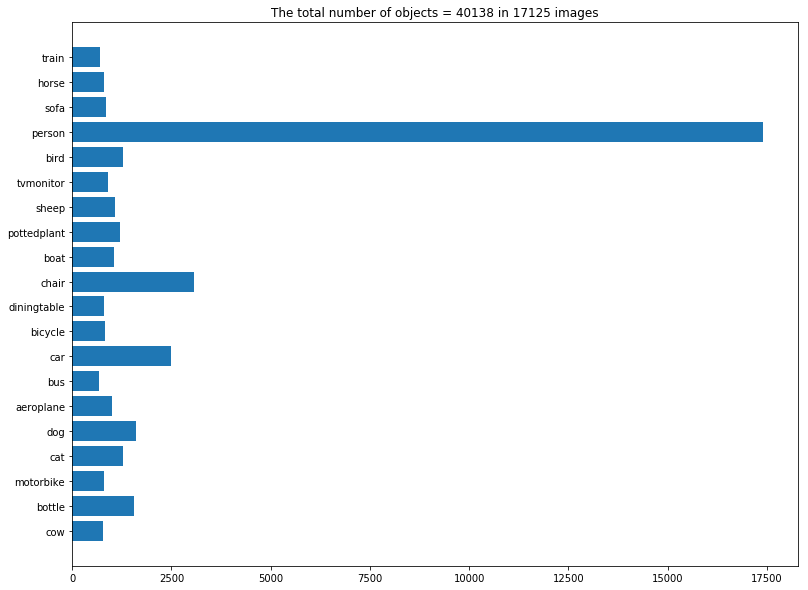

In [5]:
y_pos = np.arange(len(seen_train_labels))
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(1,1,1)
ax.barh(y_pos,list(seen_train_labels.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(seen_train_labels.keys()))
ax.set_title("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)
))
plt.show()

## K-means clustering

在论文[YOLO9000:Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf) 强烈建议我们使用聚类分析得到先验anchor的尺寸大小，原文这样说到:

<blockquote>
Dimension Clusters:
we encounter two issues with anchor boxes when using them with YOLO.
The first is that the box dimensions are hand picked. 
the network can learn to adjust the boxes appropriately but if we pick better priors for the network to start with, we can make it easier for the network to learn to predict good detections.
</blockquote>
<blockquote>
Instead of choosing priors by hand, we run k-means clustering on the training set bounding boxes to automatically find good priors. If we use standard k-means with Euclidean distance learger boxes generate more error than smaller boxes. However, what we really want are priors that lead to good IOU scores, which is indepedndent of the size of the box. Thus for our distance metric we use 1 - IOU(box,centroid)
</blockquote>
因此，让我们首先为K-means聚类准备要输入数据。 输入数据指的是ground truth bounding box的宽度和高度来作为特征。 考虑到在不同尺度下的场景中，每个boundingbox的尺寸不一。因此，非常有必要来标准化边界框的宽度和高度与图像的宽度和高度。

In [6]:
wh = []
for anno in train_image:
    aw = float(anno['width'])  # width of the original image
    ah = float(anno['height']) # height of the original image
    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"])/aw # make the width range between [0,GRID_W)
        h = (obj["ymax"] - obj["ymin"])/ah # make the width range between [0,GRID_H)
        temp = [w,h]
        wh.append(temp)
wh = np.array(wh)
print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (40138, 2)


## Visualize the clustering data
先来看看归一化后的anchor尺寸分布情况:

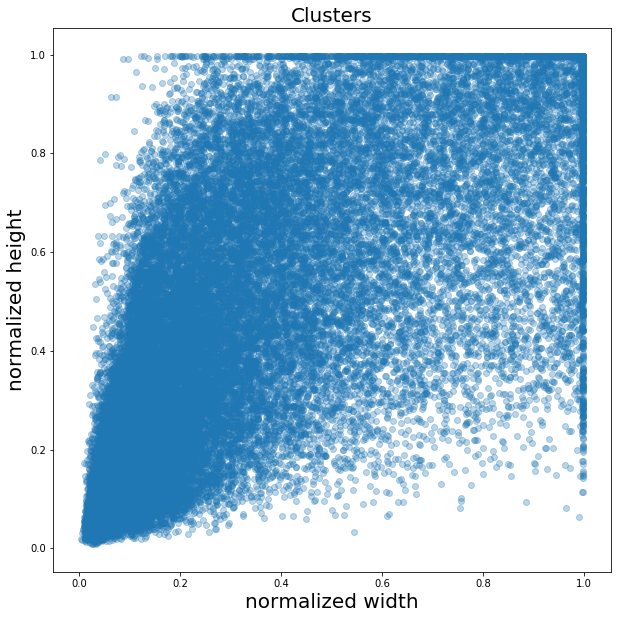

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(wh[:,0],wh[:,1],alpha=0.3)
plt.title("Clusters",fontsize=20)
plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)
plt.show()

# Intersection over union

在介绍使用K-means对先验边界框进行聚类时，非常有必要来讨论下iou的概念，因为后面我们会用它来衡量两个boundingbox之间的距离。iou是一种测量在特定数据集中检测相应物体准确度的一个标准。我们可以在很多物体检测挑战中，例如PASCAL VOC challenge中看多很多使用该标准的做法。我们计算两个bounding box的iou时，只需要使用它们的4个位置参数(xmin,ymin, width, height)，这里引用别人一张图:

<img src="https://farm8.staticflickr.com/7813/46412972842_6d2af063e9_h.jpg" width="300" height="400" alt="bbx">

iou的计算公式为: 
$$\begin{array}{rl}
IoU &= \frac{\textrm{intersection} }{
\textrm{union} - \textrm{intersection}
}\\
\textrm{intersection} &= Min(w_1,w_2)  Min(h_1,h_2)\\
\textrm{union} & = w_1 h_1 + w_2  h_2
\end{array}$$


In [8]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

## The k-means clustering

K-means的聚类方法很简单，它主要包含两个步骤:


首先初始化类别数量和聚类中心:

- Step 1: 计算每个boundingbox与所有聚类中心的距离（1-iou)，选择最近的那个聚类中心作为它的类别
- Step 2: 使用每个类别簇的均值来作为下次迭代计算的类别中心 <br>

重复步骤1和2,直至每个类别的中心位置不再发生变化。

In [9]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1) # bboxes离每一个聚类中心的最近距离

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

## The number of Clusters

一般来说，anchor聚类的类别越多，那么yolo算法就越能在不同尺度下与真实框进行回归，但是这样也增加了很多计算量。(这对于一个号称 real-time 目标检测框架来说是极其尴尬的，因此作者也尽量减少boundingbox的数目)。

In [10]:
kmax = 10
dist = np.mean
results = {}

for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4646
 3 clusters: mean IoU = 0.5391
 4 clusters: mean IoU = 0.5801
 5 clusters: mean IoU = 0.6016
 6 clusters: mean IoU = 0.6253
 7 clusters: mean IoU = 0.6434
 8 clusters: mean IoU = 0.6595
 9 clusters: mean IoU = 0.6712


类别的数量越多，每个聚类簇的均值iou就越大，说明聚类簇里的boundingbox愈加紧贴在一起。有时候很难决定类别的数目，这也是k-means的一大痛点！在yolov2论文里设置了5个先验anchor，因此先来看看聚类数目从5到8的效果吧！

### Visualization of k-means results 

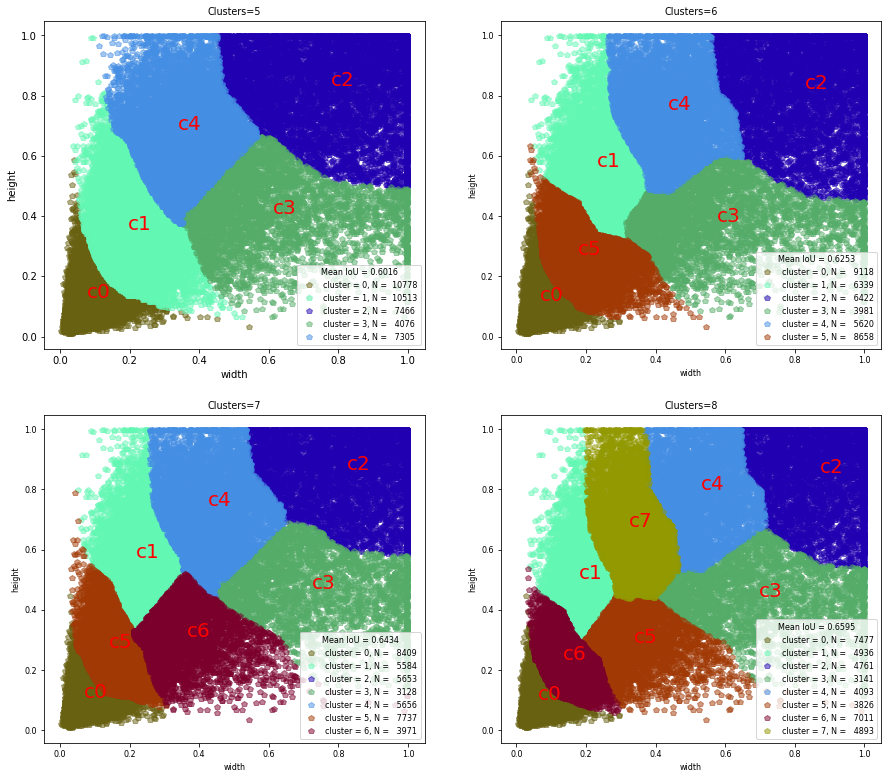

In [11]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh,k):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters=%d" %k)
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(5,9):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,wh,k)
    count += 1
plt.show()